## This notebook will use Long Short Term Memory (LSTM) to predict RUL for jet engines

In [1]:
# import the libraries
import os
import pandas as pd
import numpy as np
# import scikit-learn use pip install scikit-learn and then use the code right below this
from sklearn.preprocessing import MinMaxScaler

# %matplotlib inline
import matplotlib.pyplot as plt
import glob
import urllib
# Please note that the 'azureml' package requires an active Azure subscription 
# and Azure Machine Learning workspace for certain functionalities. 
# If you're not using Azure Machine Learning, you may need to consider whether 
# you actually need the 'azureml' package or if there's an alternative solution that suits your requirements.
# import azureml
# from azureml.logging import get_azureml_logger
# run_logger = get_azureml_logger()
# run_logger.log('amlrealworld.predictivemaintenanceforpm.dataingestionpreparation','true')

#### Import Train, Test datasets

In [2]:
# read training data 
train_raw_df = pd.read_csv('./data/train_FD001.txt', sep=" ", header=None)

# remove two columns that have NaN
# Drop columns 26 and 27
train_raw_df = train_raw_df.drop(columns=[26, 27])

# name the cols
train_raw_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_raw_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
# read test data
test_df = pd.read_csv('./data/test_FD001.txt', sep=" ", header=None)

# remove two columns that have NaN
# Drop columns 26 and 27
test_df = test_df.drop(columns=[26, 27])

# name the cols
test_df.columns = train_raw_df.columns


test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [4]:
# read ground truth data
truth_df = pd.read_csv('./data/RUL_FD001.txt', sep=" ", header=None)
# remove two columns that have NaN
# Drop column 1 which is NaN
truth_df = truth_df.drop(columns=[1])

truth_df.head()

,0
0,112
1,98
2,69
3,82
4,91


#### Training Data: Calculate the RUL for each record
##### The maximum cycle for each unit is the failure cycle.   Thus, we can use this to create the RUL of all the other cycles.

In [5]:
# create df with the unit id and the max cycle
rul = pd.DataFrame(train_raw_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul


,id,max
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


In [6]:
# join the two datasets on the unit id
train_df = train_raw_df.merge(rul, on=['id'], how='left')

# subtract cycle from the max cycles to get RUL
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df = train_df.drop(columns=[('max')])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


##### Create categorical labels
##### label1 = If RUL <=30 then flag as a "1", failure within 30 cycles
##### label2 = multiclass: If RUL <=15 then flag as a "2", failure 16 to 30 = 1, otherwise, 0

In [7]:
w1 = 30
train_df['label1'] = np.where(train_df['RUL'] <= 30, 1, 0 )
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [8]:
# label2 is multiclass, value 1 is identical to label1,
# value 2 indicates failure within 15 cycles
w0 = 15
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head(180)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1,176,-0.0020,-0.0003,100.0,518.67,642.86,1592.27,1422.73,14.62,...,8.4853,0.03,394,2388,100.0,38.72,23.2491,16,1,1
176,1,177,-0.0038,-0.0003,100.0,518.67,643.79,1602.02,1423.99,14.62,...,8.4779,0.03,396,2388,100.0,38.63,23.1673,15,1,2
177,1,178,-0.0001,0.0002,100.0,518.67,643.38,1605.33,1424.65,14.62,...,8.4770,0.03,395,2388,100.0,38.65,23.1770,14,1,2
178,1,179,0.0023,-0.0003,100.0,518.67,642.86,1592.56,1429.45,14.62,...,8.4947,0.03,395,2388,100.0,38.77,23.1888,13,1,2


##### Training Data: Normalize
We want to preserve original data: id, cycle, RUL, label1, labeel2 for interpretation, and normalize everything else. 
We also need to create a new cycle column that is normalized

In [9]:
# create new cycle col
train_df['cycle_norm'] = train_df['cycle']

# get list of cols that we want to normalize
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
# cols_normalize


In [10]:

# create minmax scaler object
min_max_scaler = MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)


#join the normalized data back to orig dataset, just getting the different cols
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


#### Test Data: Normalized

In [11]:
# create new cycle col
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


##### Test Data: Calculate RUL

In [12]:
# generate column max from the test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul.head()

# rename truth_df col from '0' to 'more'
truth_df.columns = ['more']

# # add 1 to zero based index to be equivalent to the unit id in the test dataset
truth_df['id'] = truth_df.index + 1


truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)



In [13]:
truth_df.head()

,id,max
0,1,143
1,2,147
2,3,195
3,4,188
4,5,189


In [14]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
# test_df.drop('max', axis=1, inplace=True)
test_df = test_df.drop(columns=[('max')])
test_df.head()



,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


##### Test Data: Create categorical labels

In [15]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


#### Data Viz

##### Change so showing 10 units with verticle lines at 30 and 15 cycles, and, use training data not test

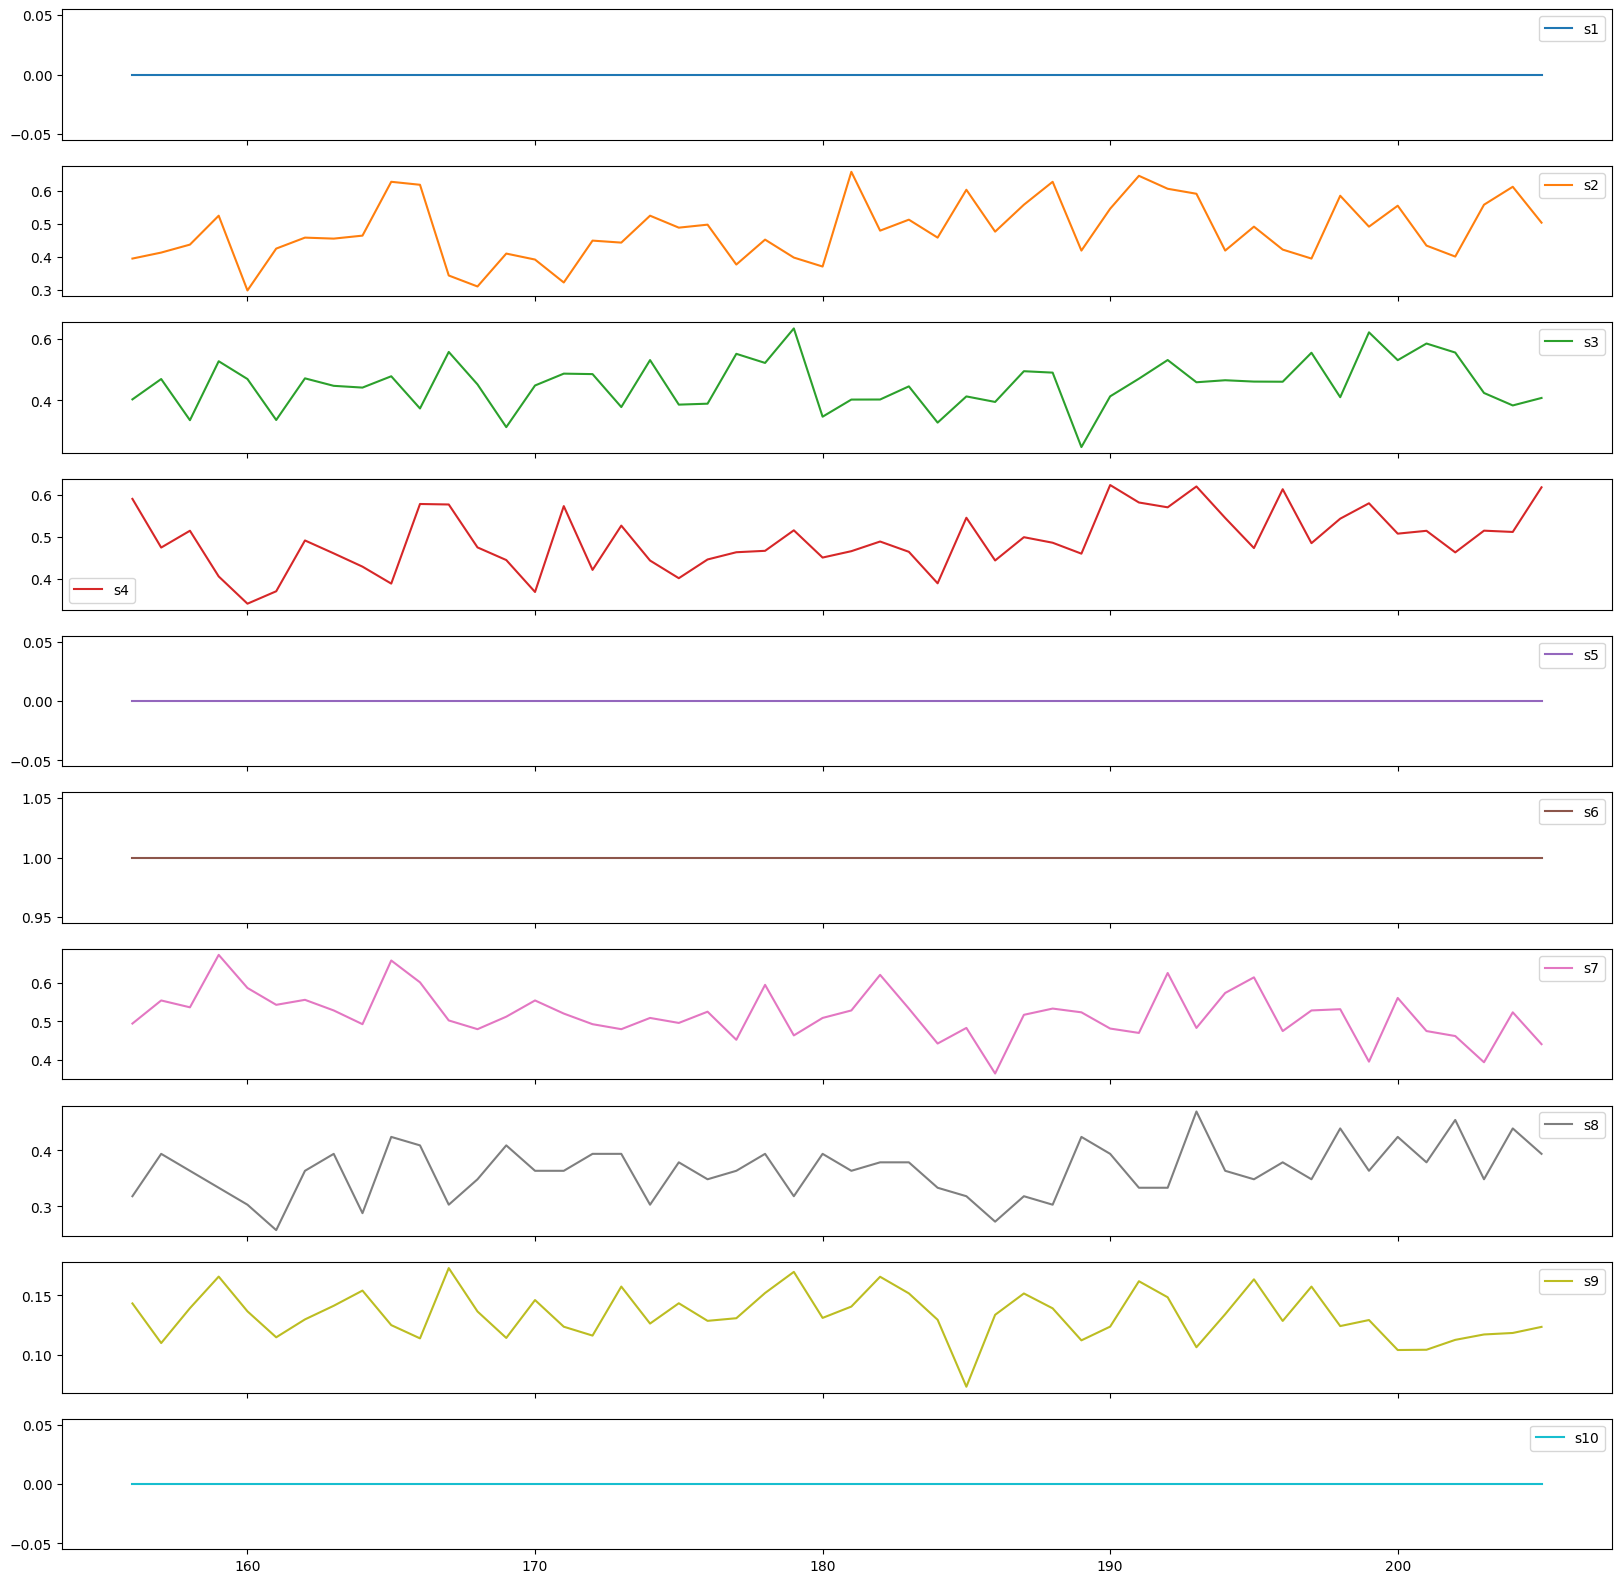

In [17]:
# get the last 50 datapoints for engine 3
engine_id3 = test_df[test_df['id'] == 3]
smallest_50_rul = engine_id3['RUL'].nsmallest(50)

# Filter the entire dataset based on the 50 smallest numbers in the "RUL" column
engine_id3 = engine_id3[engine_id3['RUL'].isin(smallest_50_rul)]

cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id3_50cycleWindow1 = engine_id3[cols1]

cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3[cols2]

# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

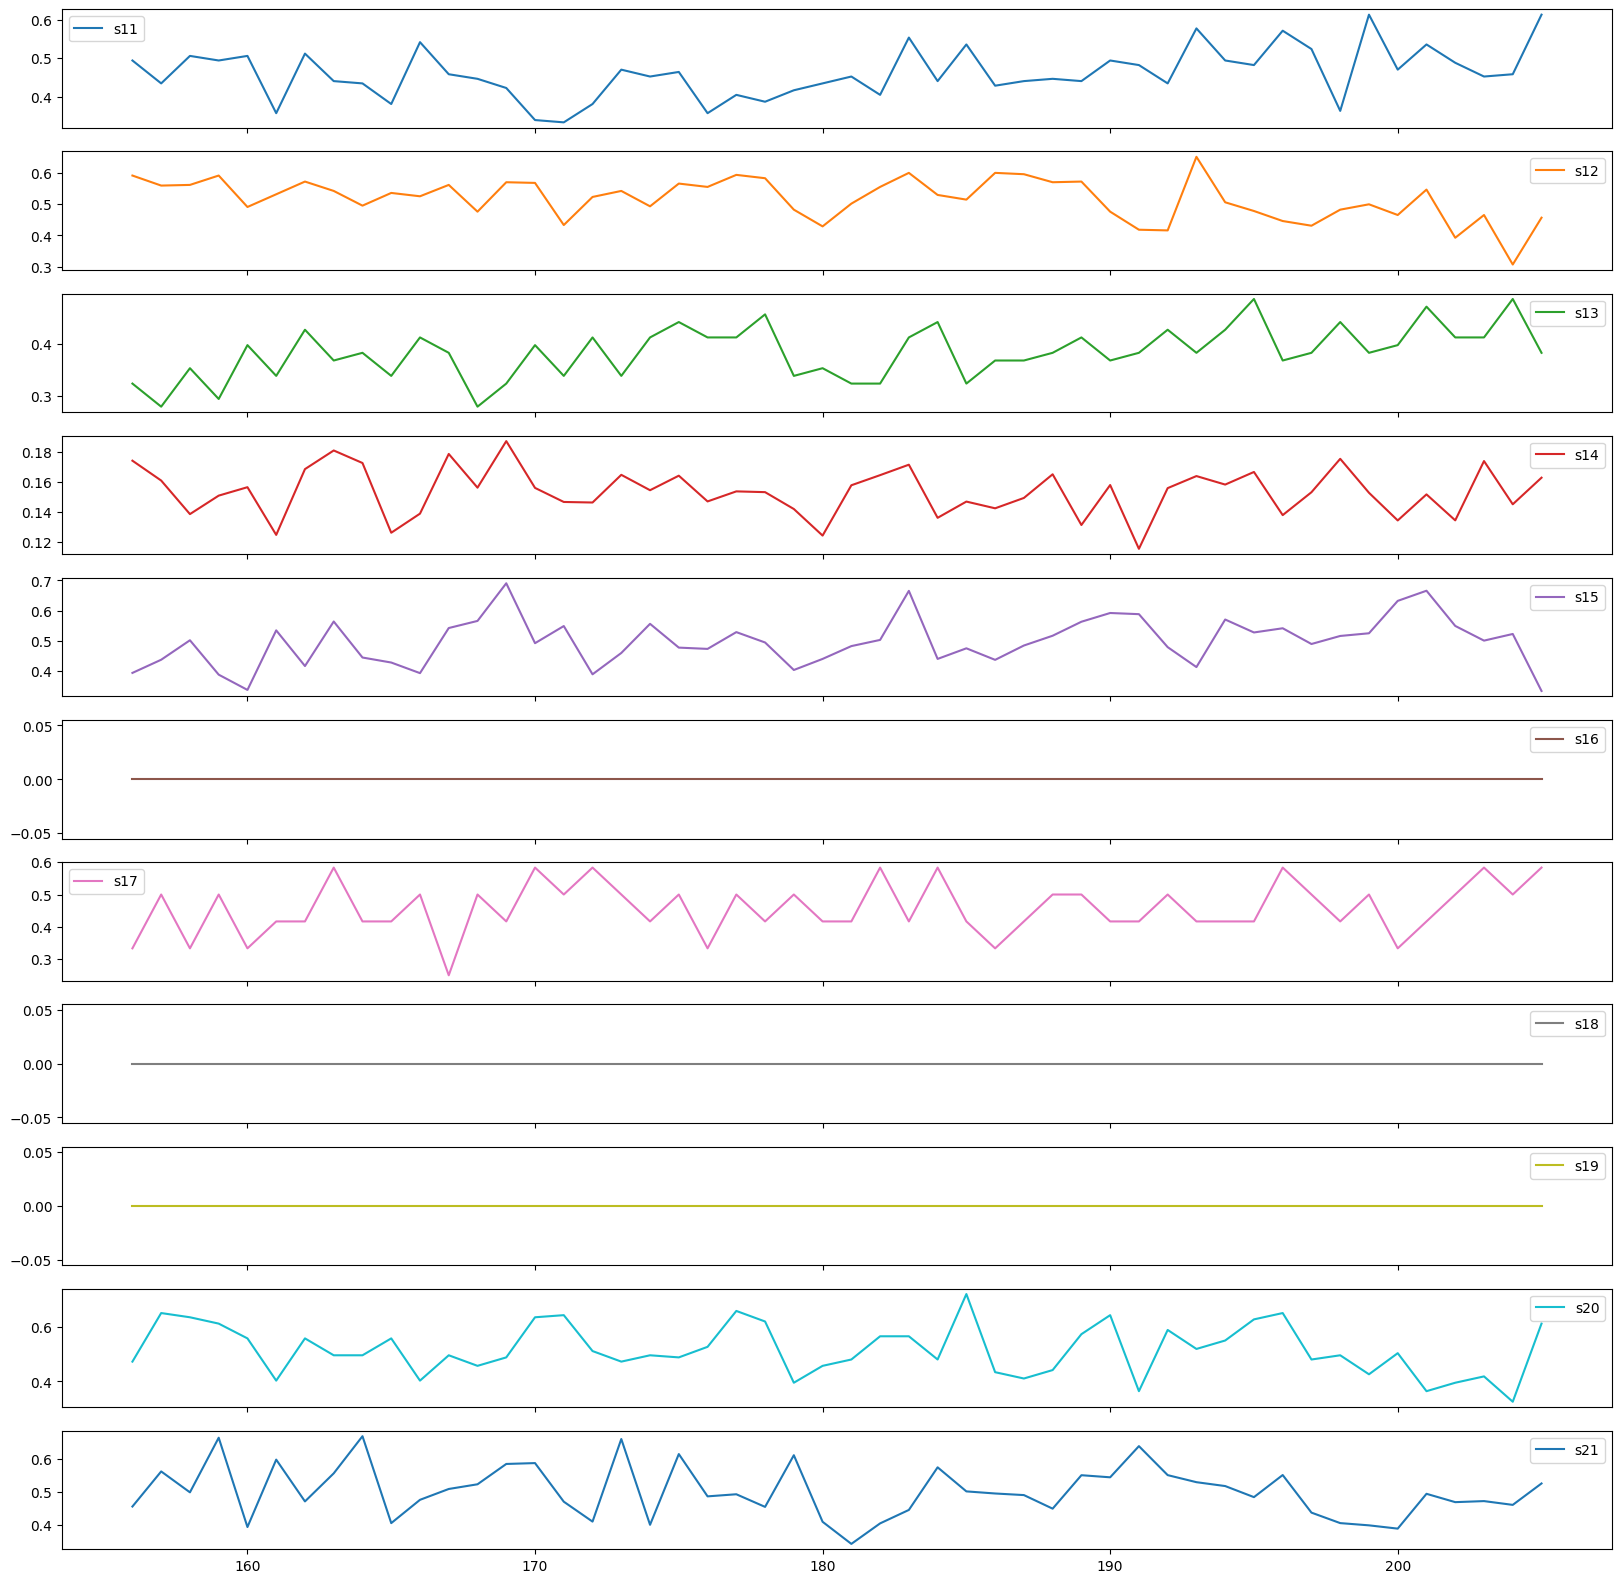

In [18]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 11-21
ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

#### Model Building
##### Import libraries

###### Tensorflow Description
Numerical Computation: TensorFlow allows you to perform mathematical operations and numerical computations efficiently. It provides a computational graph framework that represents mathematical operations as nodes and data flow as edges, enabling efficient execution on CPUs, GPUs, or even distributed computing environments.

Machine Learning: TensorFlow includes a high-level API called **Keras**, which simplifies the process of building, training, and evaluating machine learning models. Keras provides a user-friendly interface and supports a variety of neural network architectures, making it easier to implement deep learning models.

Deep Learning: TensorFlow excels in deep learning applications and supports various neural network architectures, including convolutional neural networks (CNNs) for computer vision tasks, **recurrent neural networks (RNNs) for sequential data processing**, and transformers for natural language processing (NLP) tasks. TensorFlow also provides pre-trained models and tools for transfer learning.

Model Deployment: TensorFlow allows you to export trained models and deploy them in various production environments

In [19]:
# import the libraries
import tensorflow
import keras
#HDF5 File Handling: h5py allows you to create, read, write, and manipulate HDF5 files using a simple and intuitive Pythonic interface
import h5py
import os


In [20]:
import pickle
# regular expressions
import re

In [21]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from sklearn import datasets
from keras.layers import Dense, Dropout, LSTM, Activation

##### Output files

In [22]:
# We'll serialize the model in json format
LSTM_MODEL = 'modellstm.json'

# and store the weights in h5
MODEL_WEIGHTS = 'modellstm.h5'

##### Why LSTM?
Perhaps the most attractive advantage of deep learning they automatically do feature engineering from the data, eliminating the need for the manual feature engineering step.

In [106]:
# pick a large window size of 50 cycles
sequence_length = 50

We use the Keras LSTM with Tensorflow as a backend. Here layers expect an input in the shape of an array of 3 dimensions
 (samples, time steps, features) where 
 -samples is the number of training sequences 
 -time steps is the look back window or sequence length
 -features is the number of features of each sequence at each time step

We define a function to generate this array, as we'll use it repeatedly.

In [107]:
# Get the number of rows and columns
num_rows = train_df.shape[0]
num_columns = train_df.shape[1]

# Print the result
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 20631
Number of columns: 30


In [117]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]  #rows
    
    # In Python, the zip() function is used to combine elements from two or more iterable objects 
    # and create an iterator that returns tuples containing elements from each of the iterables.
    # share = rows
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

##### Get predictor columns

In [118]:
# pick the feature columns 
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
key_cols = ['id', 'cycle']
label_cols = ['label1', 'label2', 'RUL']

input_features = test_df.columns.values.tolist()
sensor_cols = [x for x in input_features if x not in set(key_cols)]
sensor_cols = [x for x in sensor_cols if x not in set(label_cols)]
sensor_cols = [x for x in sensor_cols if x not in set(sequence_cols)]

# The time is sequenced along
# This may be a silly way to get these column names, but it's relatively clear
sequence_cols.extend(sensor_cols)

print(sensor_cols)
print(sequence_cols)

['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
['setting1', 'setting2', 'setting3', 'cycle_norm', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']


In [119]:
train_df.head(2)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277


In [120]:
train_df.tail(2)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
20629,100,199,0.436782,0.750000,0.0,0.0,0.608434,0.746021,0.747468,0.0,...,0.0,0.583333,0.0,0.0,0.116279,0.234466,1,1,2,0.548476
20630,100,200,0.316092,0.083333,0.0,0.0,0.795181,0.639634,0.842167,0.0,...,0.0,0.666667,0.0,0.0,0.178295,0.218172,0,1,2,0.551247


##### Get data in right shape

In [125]:
# this creates list of lists, where each row in array is a list with predcitor values for one unit: [0.45, 0.166, etc..], [], etc to 50
import itertools

# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# # to view the list of lists
# for item in seq_gen:
#     print(item) 
    
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

seq_array.shape  #number records, number rows in the sequence, number cols
# seq_array[0]


(15631, 50, 25)

##### Get labels

In [122]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [126]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)

label_array.shape
# label_array

(15631, 1)

##### Define the model architecture

In [129]:
# build the network
# Feature weights
# seq_array.shape  is: (15631, 50, 25)
nb_features = seq_array.shape[2]  #25 predictors

# label_array.shape is (15631, 1)
nb_out = label_array.shape[1]     #1 col?

# LSTM model
model = Sequential()

# # The first layer
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))

# Plus a 20% dropout rate
model.add(Dropout(0.2))

# The second layer
model.add(LSTM(
          units=50,
          return_sequences=False))

# Plus a 20% dropout rate
model.add(Dropout(0.2))

# Dense sigmoid layer
model.add(Dense(units=nb_out, activation='sigmoid'))

# With adam optimizer and a binary crossentropy loss. We will opimize for model accuracy.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Verify the architecture 
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 100)           50400     
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 80651 (315.04 KB)
Trainable params: 80651 (315.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


##### Fit the model

In [130]:
%%time
# fit the network
model.fit(seq_array, # Training features
          label_array, # Training labels
          epochs=10,   # We'll stop after 10 epochs
          batch_size=200, # 
          validation_split=0.10, # Use 10% of data to evaluate the loss. (val_loss)
          verbose=1, #
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', # Monitor the validation loss
                                                     min_delta=0,    # until it doesn't change (or gets worse)
                                                     patience=5,  # patience > 1 so it continutes if it is not consistently improving
                                                     verbose=0, 
                                                     mode='auto')]) 

Epoch 1/10


71/71 [==============================] - 14s 149ms/step - loss: 0.2444 - accuracy: 0.8976 - val_loss: 0.1196 - val_accuracy: 0.9546
Epoch 2/10
71/71 [==============================] - 10s 147ms/step - loss: 0.0959 - accuracy: 0.9627 - val_loss: 0.0713 - val_accuracy: 0.9738
Epoch 3/10
71/71 [==============================] - 10s 146ms/step - loss: 0.0745 - accuracy: 0.9696 - val_loss: 0.0656 - val_accuracy: 0.9776
Epoch 4/10
71/71 [==============================] - 11s 149ms/step - loss: 0.0702 - accuracy: 0.9706 - val_loss: 0.0796 - val_accuracy: 0.9674
Epoch 5/10
71/71 [==============================] - 11s 157ms/step - loss: 0.0651 - accuracy: 0.9731 - val_loss: 0.0376 - val_accuracy: 0.9866
Epoch 6/10
71/71 [==============================] - 11s 154ms/step - loss: 0.0621 - accuracy: 0.9744 - val_loss: 0.0671 - val_accuracy: 0.9636
Epoch 7/10
71/71 [==============================] - 11s 155ms/step - loss: 0.0598 - accuracy: 0.9755 - val_loss: 0.0529 - val_accuracy: 0.9731
Epoch 8/10

##### Get final metrics

In [132]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Training Accurracy: {}'.format(scores[1]))
# run_logger.log("Training Accuracy", scores[1])

79/79 [==============================] - 4s 53ms/step - loss: 0.0450 - accuracy: 0.9817
Training Accurracy: 0.9817030429840088


#### Confusion Matrix / Metrics

In [138]:
threshold = 0.5

In [139]:
# make predictions and compute confusion matrix
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_pred_out = np.where(y_pred >= threshold, 1, 0)

y_true = label_array


print('Training Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred_out)
cm

79/79 [==============================] - 4s 53ms/step
Training Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12349,   182],
       [  104,  2996]], dtype=int64)

In [150]:
# compute precision and recall
precision = precision_score(y_true, y_pred_out)
recall    = recall_score(y_true, y_pred_out)

TN = cm[0, 0]  # True negatives
FP = cm[0, 1]  # False positives
FN = cm[1, 0]  # False negatives
TP = cm[1, 1]  # True positives

specificity = TN / (TN + FP)
false_neg_rate = FN / ( FN + TP)
false_pos_rate = FP / ( FP + TN)

f1 = 2 * (precision * recall) / (precision + recall)
print( ' Training Precision: ', precision, '\n', 'Training Recall/Sensitivity: ', recall, '\n', 'Training Specificity:', specificity, '\n', 'Training F1 Score:', f1,  '\n', 
      'Training False Neg Rate:', false_neg_rate, '\n', 'Training False Pos Rate:', false_pos_rate)



 Training Precision:  0.9427312775330396 
 Training Recall/Sensitivity:  0.9664516129032258 
 Training Specificity: 0.9854760194717102 
 Training F1 Score: 0.9544440904746735 
 Training False Neg Rate: 0.03354838709677419 
 Training False Pos Rate: 0.014523980528289841


#### Model testing
Next, we look at the performance on the test data. Only the last cycle data for each engine id in the test data is kept for testing purposes. In order to compare the results to the template, we pick the last sequence for each id in the test data.

In [164]:
# dm - breaking code below into steps for understanding, using unit 3
sample  = test_df[test_df['id'] == 3] # filters for unit 3, all cols
sample1 = test_df[test_df['id'] == 3][sequence_cols] #filters cols so just predictors
sample2 = test_df[test_df['id'] == 3][sequence_cols].values # creates array where each row is now a list 
sample3 = test_df[test_df['id'] == 3][sequence_cols].values[-sequence_length:] # starts from -50 to the end, so the last 50 rows

In [174]:
sample1

,setting1,setting2,setting3,cycle_norm,s1,s2,s3,s4,s5,s6,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
80,0.494253,0.583333,0.0,0.00000,0.0,0.246988,0.411598,0.441256,0.0,1.0,...,0.748401,0.367647,0.161162,0.415929,0.0,0.333333,0.0,0.0,0.658915,0.554819
81,0.724138,0.250000,0.0,0.00277,0.0,0.307229,0.572705,0.432984,0.0,1.0,...,0.533049,0.294118,0.169006,0.359369,0.0,0.416667,0.0,0.0,0.542636,0.586716
82,0.534483,0.750000,0.0,0.00554,0.0,0.533133,0.342926,0.427583,0.0,1.0,...,0.688699,0.308824,0.161781,0.295498,0.0,0.250000,0.0,0.0,0.426357,0.667219
83,0.436782,0.416667,0.0,0.00831,0.0,0.364458,0.424678,0.323599,0.0,1.0,...,0.618337,0.308824,0.177882,0.442093,0.0,0.583333,0.0,0.0,0.449612,0.653687
84,0.477011,0.250000,0.0,0.01108,0.0,0.382530,0.262699,0.398717,0.0,1.0,...,0.571429,0.308824,0.181185,0.496730,0.0,0.333333,0.0,0.0,0.519380,0.540044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,0.626437,0.083333,0.0,0.33518,0.0,0.433735,0.584042,0.515024,0.0,1.0,...,0.545842,0.470588,0.151512,0.665641,0.0,0.416667,0.0,0.0,0.364341,0.493096
202,0.172414,0.666667,0.0,0.33795,0.0,0.400602,0.554829,0.463707,0.0,1.0,...,0.392324,0.411765,0.134173,0.549442,0.0,0.500000,0.0,0.0,0.395349,0.467827
203,0.436782,0.750000,0.0,0.34072,0.0,0.557229,0.424024,0.515361,0.0,1.0,...,0.464819,0.411765,0.173754,0.500962,0.0,0.583333,0.0,0.0,0.418605,0.471002
204,0.580460,0.666667,0.0,0.34349,0.0,0.611446,0.383693,0.512323,0.0,1.0,...,0.307036,0.485294,0.144907,0.522893,0.0,0.500000,0.0,0.0,0.325581,0.459542


In [165]:
sample2

array([[0.49425287, 0.58333333, 0.        , ..., 0.        , 0.65891473,
        0.55481911],
       [0.72413793, 0.25      , 0.        , ..., 0.        , 0.54263566,
        0.58671638],
       [0.53448276, 0.75      , 0.        , ..., 0.        , 0.42635659,
        0.667219  ],
       ...,
       [0.43678161, 0.75      , 0.        , ..., 0.        , 0.41860465,
        0.47100249],
       [0.58045977, 0.66666667, 0.        , ..., 0.        , 0.3255814 ,
        0.45954156],
       [0.40804598, 0.83333333, 0.        , ..., 0.        , 0.6124031 ,
        0.52444076]])

In [166]:
sample3

array([[0.35057471, 0.83333333, 0.        , ..., 0.        , 0.47286822,
        0.45457056],
       [0.39655172, 0.58333333, 0.        , ..., 0.        , 0.65116279,
        0.56089478],
       [0.51149425, 0.25      , 0.        , ..., 0.        , 0.63565891,
        0.4975145 ],
       ...,
       [0.43678161, 0.75      , 0.        , ..., 0.        , 0.41860465,
        0.47100249],
       [0.58045977, 0.66666667, 0.        , ..., 0.        , 0.3255814 ,
        0.45954156],
       [0.40804598, 0.83333333, 0.        , ..., 0.        , 0.6124031 ,
        0.52444076]])

In [172]:
# dm - getting an idea of the shape of the final test df
test = []
for id in test_df['id'].unique():
    if len(test_df[test_df['id'] == id]) >= 50:
        test.append(id)
len(test)
print("There are",len(test), "units that have >50 records for a total of", len(test)*50, "records" )

There are 93 units that have >50 records for a total of 4650 records


##### Test Data: Convert to array

In [153]:
# dm - for each unit w/at least 50 records, create list of lists where each unit becomes a list, 
# and each row for that unit becomes nested list.  
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape #number of unique unit lists, number of nested lists (50), number of columns

(93, 50, 25)

In [173]:
seq_array_test_last

array([[[0.3505747 , 0.8333333 , 0.        , ..., 0.        ,
         0.4728682 , 0.45457056],
        [0.39655173, 0.5833333 , 0.        , ..., 0.        ,
         0.6511628 , 0.5608948 ],
        [0.5114943 , 0.25      , 0.        , ..., 0.        ,
         0.6356589 , 0.4975145 ],
        ...,
        [0.43678162, 0.75      , 0.        , ..., 0.        ,
         0.41860464, 0.4710025 ],
        [0.5804598 , 0.6666667 , 0.        , ..., 0.        ,
         0.3255814 , 0.45954156],
        [0.40804598, 0.8333333 , 0.        , ..., 0.        ,
         0.6124031 , 0.52444077]],

       [[0.55172414, 0.25      , 0.        , ..., 0.        ,
         0.5503876 , 0.6974593 ],
        [0.39655173, 0.5833333 , 0.        , ..., 0.        ,
         0.37209302, 0.59748685],
        [0.5344828 , 0.16666667, 0.        , ..., 0.        ,
         0.51937985, 0.602596  ],
        ...,
        [0.43103448, 0.33333334, 0.        , ..., 0.        ,
         0.56589144, 0.49461475],
        [0.3

##### Get ids >= threshold 

In [176]:
# dm - boolean list
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
print(y_mask)


[False, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


##### Get labels

In [183]:
# dm - filter test_df for the ids where y_mask is True
# .nth(-1) is used as part of the groupby() operation in pandas to retrieve the last value within each group
# this will indicate if the 50th record was a 0 or 1
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
print(label_array_test_last)
print(label_array_test_last.shape)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0
 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1]
(93,)


Now we can test the model with the test data. We report the model accuracy on the test set, and compare it to the training accuracy. By definition, the training accuracy should be optimistic since the model was optimized for those observations. The test set accuracy is more general, and simulates how the model was intended to be used to predict forward in time. This is the number we should use for reporting how the model performs.

##### Get Test scores

In [184]:
# dm - verbose=0: Silent mode. No output is displayed during the evaluation process.
# verbose=1: Progress bar mode. A progress bar is displayed, showing the progress of the evaluation.
# verbose=2: One line per epoch mode. A single line is displayed for each evaluation epoch, providing summary information.

# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Test Accurracy: {}'.format(scores_test[1]))


3/3 - 1s - loss: 0.0506 - accuracy: 0.9677 - 799ms/epoch - 266ms/step
Test Accurracy: 0.9677419066429138


##### Confusion Matrix / Metrics

In [185]:
# # make predictions and compute confusion matrix
# y_pred_test = model.predict_classes(seq_array_test_last)
# y_true_test = label_array_test_last
# print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
# cm = confusion_matrix(y_true_test, y_pred_test)
# cm

# make predictions and compute confusion matrix
y_pred_test = model.predict(seq_array_test_last)
y_pred_test_out = np.where(y_pred_test >= threshold, 1, 0)

y_true_test = label_array_test_last


print('Training Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test_out)
cm

3/3 [==============================] - 0s 15ms/step
Training Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[66,  2],
       [ 1, 24]], dtype=int64)

The confusion matrix uses absolute counts, so comparing the test and training set confusion matrices is difficult. Instead, it is better to use precision and recall.

Precision measures how accurate your model predicts failures. What percentage of the failure predictions are actually failures.
Recall measures how well the model captures thos failures. What percentage of the true failures did your model capture.
These measures are tightly coupled, and you can typically only choose to maximize one of them (by manipulating the probability threshold) and have to accept the other as is.

In [187]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test_out)
recall_test    = recall_score(y_true_test, y_pred_test_out)

TN = cm[0, 0]  # True negatives
FP = cm[0, 1]  # False positives
FN = cm[1, 0]  # False negatives
TP = cm[1, 1]  # True positives

specificity_test = TN / (TN + FP)
false_neg_rate_test = FN / ( FN + TP)
false_pos_rate_test = FP / ( FP + TN)


f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)

print( ' Test Precision: ', precision_test, '\n', 'Test Recall/Sensitivity: ', recall_test, '\n', 'Test Specificity:', specificity_test, '\n', 'Test F1 Score:', f1_test,  '\n', 
      'Test False Neg Rate:', false_neg_rate_test, '\n', 'Test False Pos Rate:', false_pos_rate_test)


 Test Precision:  0.9230769230769231 
 Test Recall/Sensitivity:  0.96 
 Test Specificity: 0.9705882352941176 
 Test F1 Score: 0.9411764705882353 
 Test False Neg Rate: 0.04 
 Test False Pos Rate: 0.029411764705882353
